## MNIST: Train Convolutional Neural Network (w/ batch norm) using Tensorflow 

**Dataset:** 
- MNIST Dataset
- http://yann.lecun.com/exdb/mnist/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

## Load MNIST Data

- Same help code from the previous "Classification_Tensorflow" notebook to load in the MNIST dataset. This notebook will explore a different structure of coding up the nerual network. We will also examine using batch normalization to increase accuracy of the model. 

In [2]:
# Get Data From Tensorflow Tutorial and save copy to local directory
from tensorflow.examples.tutorials.mnist import input_data

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Original Training Shape: (55000, 784)
Original Validation Shape: (5000, 784)
Original Testing Shape: (55000, 784)
Reformat to 28x28 Pixels Shape: (55000, 28, 28)


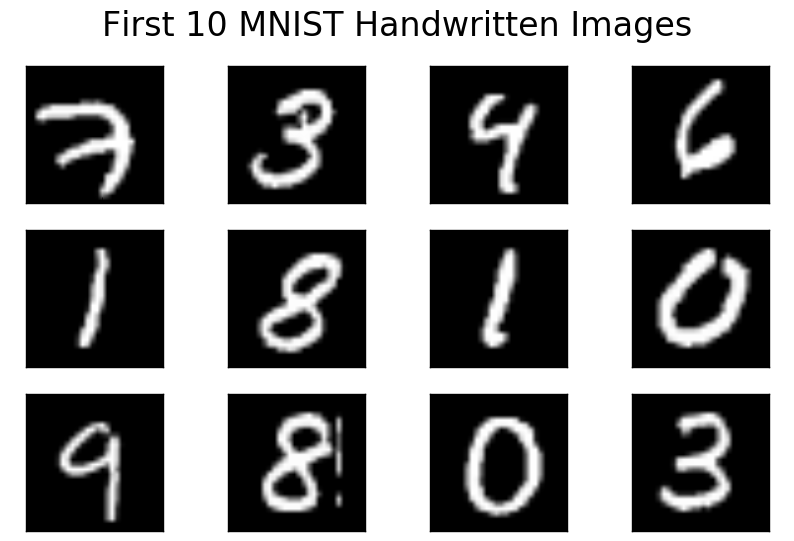

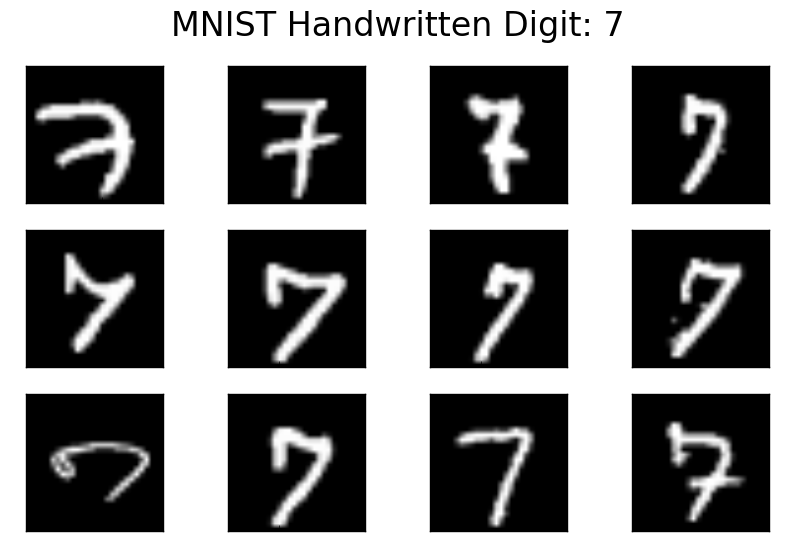

In [3]:
def process_data(mnist):
    
    """
    Return preprocessed Training/Testing subsets of the MNIST Images
    
    Keyword arguments:
    None
    """
    
    X_train = mnist.train.images
    X_val = mnist.validation.images
    X_test = mnist.test.images
    print('Original Training Shape:',X_train.shape)
    print('Original Validation Shape:',X_val.shape)
    print('Original Testing Shape:',X_train.shape)

    
    # Training/Testing Labels
    y_train,y_val,y_test = mnist.train.labels,mnist.validation.labels,mnist.test.labels
    
    # Reshape Data into 28x28 pixels
    X_train_reshape = X_train.reshape(X_train.shape[0],28,28)
    X_test_reshape = X_test.reshape(X_test.shape[0],28,28)
    
    print('Reformat to 28x28 Pixels Shape:',X_train_reshape.shape)
    return(X_train,X_val,X_test,y_train,y_val,y_test,X_train_reshape,X_test_reshape)

def explore_images(X,images=10):
    n_col = 4
    n_row = int(np.ceil(images/n_col))
    
    fig = plt.figure(figsize=(2.5*n_col,2.0*n_row))
    plt.title('First %.0f MNIST Handwritten Images' % images, fontsize=24,y=1.05)
    plt.box(False)
    plt.xticks(())
    plt.yticks(())
    for img,i in enumerate(range(n_row*n_col)):
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.imshow(X[img],cmap='gray',interpolation=None)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        
def explore_specific_digits(X,y,digit,images=10):
                            
    X = X[np.argmax(y,axis=1) == digit]
    
    n_col = 4
    n_row = int(np.ceil(images/n_col))
    
    fig = plt.figure(figsize=(2.5*n_col,2.0*n_row))
    plt.title('MNIST Handwritten Digit: %s' % digit, fontsize=24,y=1.05)
    plt.box(False)
    plt.xticks(())
    plt.yticks(())
    for img,i in enumerate(range(n_row*n_col)):
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.imshow(X[img],cmap='gray',interpolation=None)
        ax.set_xticklabels('')
        ax.set_yticklabels('')

        
if __name__ == '__main__':
    
    #Load MNIST and store locally
    mnist = input_data.read_data_sets('data/MNIST_data',one_hot=True)
    
    #Prep Data
    X_train,X_val,X_test,y_train,y_val,y_test,X_train_reshape,X_test_reshape = process_data(mnist)
    
    #Explore Images
    explore_images(X_train_reshape)
    
    #Explore Specific Digits
    explore_specific_digits(X_train_reshape,y_train,7)

_____
## Build Neural Network

- In the code blocks below, we will construct a feed-forward neural network -- MLP Classifier. Although, the code is functionable to handle a deep network, the number of hidden layers for this example will be 2 Recall, the objective is to correctly classify MNIST Handwritten Images: [0-9]

- **Architecture:**

    - Input Dimensions: 784 
    - Hidden Layers: 2
    - Units in Each Layer: 100
    - Output: 10
    
    
### Multi-Layer Feedforward Neural Network w/ Batch Normalization 

Rather than only normalizing the inputs to a neural network, the inputs to layers within the network will be normalized. During training, each layer's inputs are normalized by taking the mean and variance of the values of the mini-batch. The code below will illustrate an example of using this method. A couple of advantages of using batch normalization are the following: faster training by using higher learning rates, easier initialization of weights, allows for deeper networks, provides a bit of regularization. These benefits can lead to better results. 

- No bias term: Reason is that the calculations has gamma & beta variables --> bias is unnecessary

In [41]:
class Neural_Network(object):
    
    "Develop a Multi-Layer Feedforward Neural Network utilizing the Tensorflow API"
    
    def __init__(self, initial_weights, activation_fn, batch_norm):
        
        """
        Parameters:
        ------------
        initial_weights: dictionary of initial weights with hidden layer size
        activation_fn: non-linear activation function (i.e. relu, leaky relu, tanh, sigmoid)
        batch_norm: Boolean value depicting if batch normaliztion is applied
        """

        # Argument to use toggle between implementing batch norm 
        self.batch_norm = batch_norm
        self.name = "Batch Normalization" if batch_norm else "Without Batch Normalization"

        # Batch normalization needs to do different calculations during training
        self.is_training = tf.placeholder(tf.bool, name= "is_training")

        # Store Accuracies
        self.training_accuracies = []
        self.testing_accuracies = []

        # Initialize Build
        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        
        """
        Parameters:
        ------------
        initial_weights: dictionary of initial weights with hidden layer size
        activation_fn: non-linear activation function (i.e. relu, leaky relu, tanh, sigmoid)
        """
        
        # Input Dimensions of Neural Network
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights['input_dim'][0].shape[0]])
        layer_in = self.input_layer
        
        # Feedforward Pass for Each Layer --> except for output layer
        for weights in [w for k,w in initial_weights.items() if k not in 'output_dim']:
            layer_in = self.fully_connected(layer_in, weights[0], activation_fn)    
          
         # Output dimensions 
        self.output_layer = self.fully_connected(layer_in, initial_weights['output_dim'][0])
        
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):

        # Batch Normalization and Activation Function args == True
        if self.batch_norm and activation_fn:

            # Matrix Multiplication Operation
            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)

            # Apply Batch Normalization --> input argument training: boolean 
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)

            # Apply the activation function
            return activation_fn(batch_normalized_output)
        
        # Output Layer
        else: 
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            
            #If Activation Function == None --> output linear_output 
            return linear_output if not activation_fn else activation_fn(linear_output)
    
    def train(self,X_train,X_val,y_train,y_val,session,learning_rate,batches,
              batches_per_sample,output_dim,save_=None):

        # Placeholder will store target labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, output_dim])

        # Loss Function
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))
                    
        # Define operations for testing validation set
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # When performing batch normalization --> must include update ops to update each layers statistics
        if self.batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        # Train model for the specified number of batches
        for i in tqdm.tqdm(range(batches)):
            
            # Random Mini-Batch Sample --> Training Set
            batch_x_train, batch_y_train = get_random_sample(X_train,y_train,batches_per_sample)
            batch_x_val, batch_y_val = get_random_sample(X_val,y_val,batches_per_sample)

            # Compute Loss on Training Set
            session.run(train_step,feed_dict={self.input_layer: batch_x_train, 
                                             labels: batch_y_train,self.is_training: True})
            
            # Periodically Get Accuracy Score for Random Sample from Validation Set
            if i % batches_per_sample == 0:
                self.training_accuracies.append(session.run(accuracy,feed_dict={self.input_layer: batch_x_val,
                                                               labels: batch_y_val,self.is_training: True}))

        val_accuracy = session.run(accuracy,feed_dict={self.input_layer: X_val, labels: y_val,self.is_training: True})
        
        print('='*65)
        print('Average Validation Set Accuracy {0} = {1:.3f}%'.format(self.name, val_accuracy*100))
    
        #Save Model if not None
        if save_:
            tf.train.Saver().save(session, save_model_as)
            
    def test(self,X_test,y_test,session,output_dim):

        # Placeholder will store target labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, output_dim])

        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # Test against all test data
        self.testing_accuracies.append(session.run(accuracy, feed_dict={self.input_layer: X_test,
                                                         labels: y_test,
                                                         self.is_training: False}))

        print('Average Test Set Accuracy {0} = {1:.3f}%'.format(self.name, np.mean(self.testing_accuracies)*100))

** Run Model**

In [56]:
def get_random_sample(X,y,batch_sample):
    # Random Mini-Batch Sample
    rand_idx = np.random.choice(len(X),size=batch_sample)
    batch_x,batch_y = X[rand_idx],y[rand_idx]
    return batch_x, batch_y
    
def plot_accuracies(*args,**kwargs):
    
    """ Plot Validation Accuracy"""
    
    sample_size = kwargs['batch_sample_size']

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    colors = ['teal','orange','blue','coral']
    for idx,arg in enumerate(args):
        ax.plot(range(0,len(arg.training_accuracies)*sample_size,sample_size),
            arg.training_accuracies,lw=2.0,color=colors[idx],label=arg.name)
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,1)
        ax.set_xlabel('Number of Batches')
        ax.legend(frameon=False,loc=(1.01,0.50))
        ax.set_title('Validation Accuracy Score',y=1.02)
    plt.grid(True)
    
def get_nn_architecture(input_dim=784,output_dim=10):
    
    params = OrderedDict()
    
    # Initialize Random Weights and Specify Tensor Shapes
    params['input_dim'] =  np.random.normal(size=(input_dim,100), scale=0.5).astype(np.float32),
    params['layer1_hidden'] = np.random.normal(size=(100,100), scale=0.5).astype(np.float32),
    params['layer2_hidden'] = np.random.normal(size=(100,100), scale=0.5).astype(np.float32),
    params['output_dim'] = np.random.normal(size=(100,output_dim), scale=0.5).astype(np.float32),

    return params

def train_and_test(X_train,X_val,X_test,y_train,y_val,y_test,learning_rate,activation_fn,n_batches,batch_size):

    # Initialize weights
    weights = get_nn_architecture()

    # Reset default graph if training two different models (i.e. with or w/out batch_norm)
    tf.reset_default_graph()

    # Create Batch-Normalization instance of Neural Network
    nnet_batch_norm = Neural_Network(weights, activation_fn, True)
    nnet = Neural_Network(weights, activation_fn, False)
    
    # Train Model
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
    
        # Training
        nnet_batch_norm.train(X_train,X_val,y_train,y_val,sess,learning_rate,n_batches,batch_size,weights['output_dim'][0].shape[1])
        nnet.train(X_train,X_val,y_train,y_val,sess,learning_rate,n_batches,batch_size,weights['output_dim'][0].shape[1])
        
        # Testing Model
        nnet_batch_norm.test(X_test,y_test,sess,weights['output_dim'][0].shape[1])
        nnet.test(X_test,y_test,sess,weights['output_dim'][0].shape[1])
        
    plot_accuracies(nnet_batch_norm,nnet, batch_sample_size=batch_sample_size)

  0%|          | 0/50000 [00:00<?, ?it/s]

Average Validation Set Accuracy Batch Normalization = 92.060%


100%|██████████| 50000/50000 [03:18<00:00, 252.19it/s]


Average Validation Set Accuracy Without Batch Normalization = 93.040%
Average Test Set Accuracy Batch Normalization = 91.600%
Average Test Set Accuracy Without Batch Normalization = 92.700%
CPU times: user 38min 33s, sys: 4min 21s, total: 42min 54s
Wall time: 9min 20s


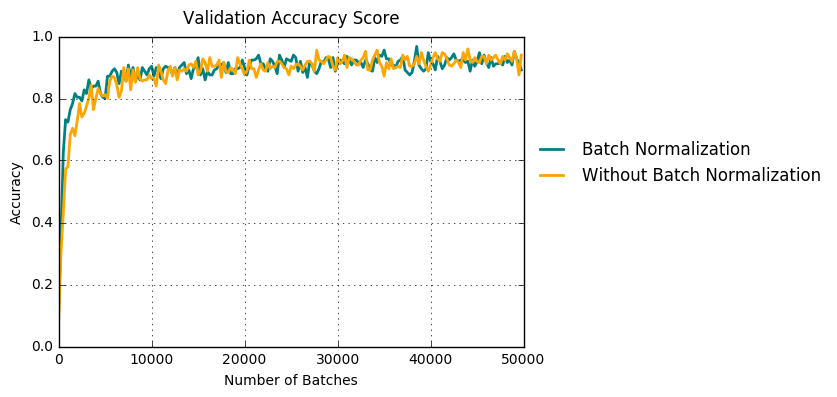

In [57]:
if __name__ == '__main__':
    
    learning_rate = 0.01
    activation_funct = tf.nn.sigmoid
    n_batches = 50000
    batch_sample_size = 250
    
    %time results = train_and_test(X_train,X_val,X_test,y_train,y_val,y_test,learning_rate,activation_funct,n_batches,batch_sample_size)

100%|██████████| 50000/50000 [05:44<00:00, 145.03it/s]


Average Validation Set Accuracy Batch Normalization = 94.340%


100%|██████████| 50000/50000 [03:21<00:00, 248.27it/s]


Average Validation Set Accuracy Without Batch Normalization = 89.000%
Average Test Set Accuracy Batch Normalization = 93.850%
Average Test Set Accuracy Without Batch Normalization = 88.400%
CPU times: user 38min 31s, sys: 4min 27s, total: 42min 58s
Wall time: 9min 8s


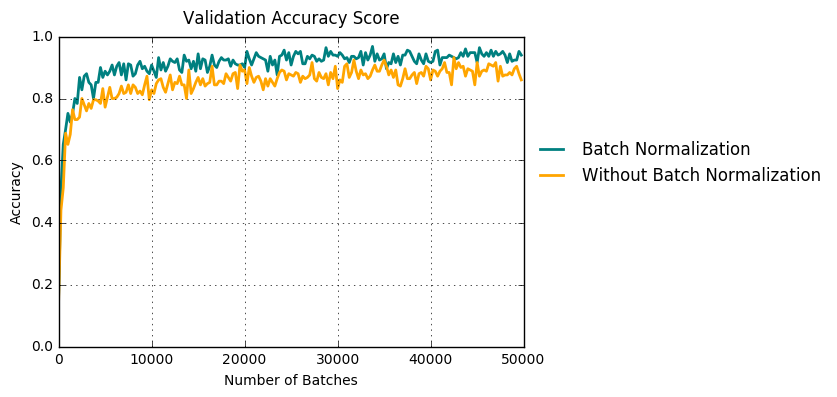

In [58]:
activation_funct = tf.nn.tanh
%time train_and_test(X_train,X_val,X_test,y_train,y_val,y_test,learning_rate,activation_funct,n_batches,batch_sample_size)